In [ ]:
from math import *
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
import numpy as np

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
#Construction de 10000 points sur l'intervalle [0,pi/2]
x_inputs_2 = np.linspace(0,pi/2,10000)

In [ ]:
#Construction de 10000 points sur l'intervalle [0,pi/2]
x_inputs = np.linspace(0,pi/2,10000)

In [ ]:
#Observations : sinus avec variation d'amplitude + un bruit
def d(x) :
    wc = 5
    wm = 4
    m = lambda x : sin(wm*x)
    y = m(x) * sin(wc*x)
    var = 0.02 + 0.02 * (1-m(x))**2
    return y + np.random.normal(0,np.sqrt(var))

In [ ]:
#Moyenne des observations
def y(x) :
    wc = 5
    wm = 4
    m = lambda x : sin(wm*x)
    return m(x) * sin(wc*x)

In [ ]:
#Variance du bruit
def noise(x) :
    wc = 5
    wm = 4
    m = lambda x : sin(wm*x)
    return 0.02 + 0.02 * (1-m(x))**2

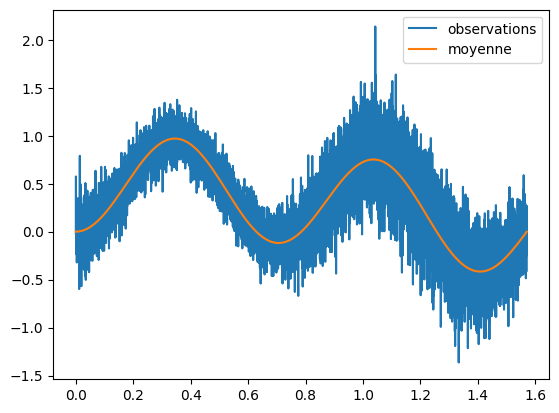

In [ ]:
#Affichage des observations et de la moyenne
plt.plot(x_inputs,[d(xi)for xi in x_inputs],label = "observations")
plt.plot(x_inputs,[y(xi)for xi in x_inputs],label="moyenne")
plt.legend()
plt.show()

In [ ]:
# Construction de la liste des observations
d_outputs_2= []
for xi in x_inputs:
  d_outputs_2.append(d(xi))

In [ ]:
# Construction de la liste des observations
d_outputs = []
for xi in x_inputs:
  d_outputs.append(d(xi))

In [ ]:
# Conversions des listes/array en tensor et construction des dataloaders
x_inputs = torch.tensor(x_inputs, dtype=torch.float32).reshape(-1, 1)
d_outputs = torch.tensor(d_outputs, dtype=torch.float32).reshape(-1, 1)

dataset = torch.utils.data.TensorDataset(x_inputs, d_outputs)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=10000, shuffle=False)


In [ ]:
def build_design_matrix(x, knots):
    """
    x     : (N,)
    knots : (K,)
    H     : (N, K+1)
    """
    N = x.shape[0]
    K = knots.shape[0]

    H = np.ones((N, K + 1))  # h0(x) = 1

    for k in range(K):
        H[:, k + 1] = np.maximum(0.0, x - knots[k])

    return H


In [ ]:
knots = np.linspace(0, pi/2, 50)
H = build_design_matrix(x_inputs_2, knots)

In [ ]:
alpha, residuals, rank, s = np.linalg.lstsq(H, d_outputs_2, rcond=None)

In [ ]:
def least_squares_piecewise_tensor(x, alpha, knots):
    """
    x     : tensor (N,) ou (N,1)
    alpha : tensor (K+1,) ou array
    knots : tensor (K,) ou array
    """
    # s = alpha_0 (broadcast sur toutes les valeurs de x)
    s = alpha[0] * torch.ones_like(x)

    # somme des bases ReLU
    for k in range(len(knots)):
        s += alpha[k + 1] * torch.relu(x - knots[k])

    return s

In [ ]:
def least_squares_piecewise(x, alpha, knots):
    s = alpha[0]
    for k in range(len(knots)):
        s += alpha[k + 1] * max(0.0, x - knots[k])
    return s




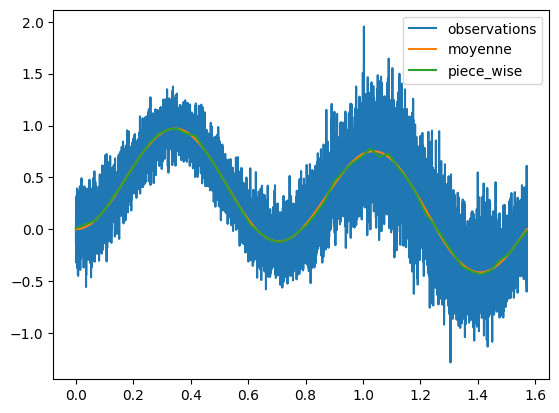

In [ ]:
#Affichage des observations et de la moyenne
plt.plot(x_inputs_2,[d(xi)for xi in x_inputs_2],label = "observations")
plt.plot(x_inputs_2,[y(xi)for xi in x_inputs_2],label="moyenne")
plt.plot(x_inputs_2,least_squares_piecewise_tensor(x_inputs,alpha,knots),label="piece_wise")
plt.legend()
plt.show()

In [ ]:
#Modeling variance by a piece wise linear function
#Trying training parameter one after another to avoid issues caused by parameter coupling

In [ ]:
# Réseau pour prédire la moyenne
# environ 1000 paramètres pour 10000 points
# La solution idéale doit être une fonction affine par morceaux qui approxime la moyenne tous les 20 points
class Net_y_1(nn.Module):
    def __init__(self):
        super(Net_y_1,self).__init__()
        self.fc1 = nn.Linear(1, 50)
        self.fc2 = nn.Linear(50,1)
                # Initialisation personnalisée
        with torch.no_grad():
            # Poids = 1
            self.fc1.weight.fill_(1.0)

            # Biais = 0, 20, 40, ..., 9980
            self.fc1.bias.copy_(torch.arange(0, 10000, 200))

        # Optionnel : geler la première couche
        self.fc1.weight.requires_grad = False
        self.fc1.bias.requires_grad = False



    def forward(self,x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return torch.relu(x)

In [ ]:
def train_one_fc2_weight(model, index):
    """
    index : indice du neurone ReLU à entraîner
    """

    mask = torch.zeros_like(model.fc2.weight)
    mask[0, index] = 1.0

    def hook(grad):
        return grad * mask

    return model.fc2.weight.register_hook(hook)


In [ ]:
model = Net_y_1()

criterion = nn.GaussianNLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1
                            )

In [ ]:
for i in range(1):
    x_interval = x_inputs[200*i:200*(i+1)]
    d_interval = d_outputs[200*i:200*(i+1)]
    print(f"Training weight {i}")

    # Hook pour entraîner seulement fc2.weight[0, i]
    hook_handle = train_one_fc2_weight(model, i)

    for epoch in range(50):
        optimizer.zero_grad()
        var_output = model(x_interval)
        mean_output = least_squares_piecewise_tensor(x_interval,alpha,knots)
        loss = criterion(d_interval,mean_output,var_output)
        loss.backward()
        optimizer.step()
        train_loss = loss.item()
        print('epoch: {} \ttraining Loss: {:.6f}'.format(epoch+1, train_loss))

    # Supprimer le hook après entraînement
    hook_handle.remove()


In [ ]:
#Even first parameter doesn't change with training
#As i did not find the solution to this, i will decouple parameters by using a non continuous piece wise linear function
#It's less good as physical signal shouldn't have discontinuity but we will see how reliable it can be in our case

In [ ]:
class PiecewiseAffine(nn.Module):
    def __init__(self, n_intervals):
        super().__init__()
        self.slopes = nn.Parameter(torch.zeros(n_intervals))
        self.biases = nn.Parameter(torch.zeros(n_intervals))

    def forward(self, x):
        # x shape (N, 1) ou (N,)
        x = x.squeeze(-1)
        idx = (x // 20).long().clamp(min=0, max=len(self.slopes)-1)
        return torch.exp(self.slopes[idx] * x + self.biases[idx])


In [ ]:
model = PiecewiseAffine(500)
#with torch.no_grad():
    #model.biases.fill_(-3)

criterion = nn.GaussianNLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1)

In [ ]:
x_interval = x_inputs
d_interval = d_outputs


for epoch in range(1000):
    #if epoch == 500:      # par exemple
      #for g in optimizer.param_groups:
        #g['lr'] = 1e-8  # nouveau LR
    optimizer.zero_grad()
    var_output = model(x_interval)
    mean_output = least_squares_piecewise_tensor(x_interval,alpha,knots)
    loss = criterion(d_interval,mean_output,var_output)
    loss.backward()
    optimizer.step()
    train_loss = loss.item()
    print('epoch: {} \ttraining Loss: {:.6f}'.format(epoch+1, train_loss))


In [ ]:
# Initialisation du device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

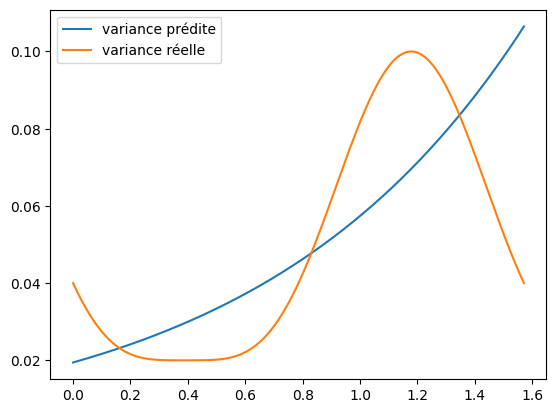

In [ ]:
# Affichage de la variance prédite

x_inputs
with torch.no_grad():
    y_pred = model(x_inputs)
plt.plot(x_inputs.cpu(), y_pred.cpu(),label = "variance prédite")
plt.plot(x_inputs.cpu(),[var(xi) for xi in x_inputs], label = "variance réelle")
plt.legend()
plt.show()

In [ ]:
#Despite parameter decoupling the function is still continuous somehow
#No local variations is learned

In [ ]:
#Now we're going for a full neural network approach
#We directly use GaussianNLLLoss

In [ ]:
# Réseau avec beaucoup plus de paramètres que d'observations
class Net_y_3(nn.Module):
    def __init__(self):
        super(Net_y_3,self).__init__()
        self.fc1 = nn.Linear(1, 1000)
        self.fc2 = nn.Linear(1000,1000)
        self.fc3 = nn.Linear(1000,1000)
        self.fc4 = nn.Linear(1000,1000)
        self.fc5 = nn.Linear(1000,1000)
        self.fc6 = nn.Linear(1000,1000)
        self.fc7 = nn.Linear(1000,1000)
        self.fc8 = nn.Linear(1000,1000)
        self.fc9 = nn.Linear(1000,1000)
        self.fc10 = nn.Linear(1000,1)



    def forward(self,x):
        x_scaled = (x - np.pi/2) / (np.pi/2)  # x_scaled ∈ [-1,1]
        x = self.fc1(x)
        x = F.tanh(x)
        x = self.fc2(x)
        x = F.tanh(x)
        x = self.fc3(x)
        x = F.tanh(x)
        x = self.fc4(x)
        x = F.tanh(x)
        x = self.fc5(x)
        x = F.tanh(x)
        x = self.fc6(x)
        x = F.tanh(x)
        x = self.fc7(x)
        x = F.tanh(x)
        x = self.fc8(x)
        x = F.tanh(x)
        x = self.fc9(x)
        x = F.tanh(x)
        x = self.fc10(x)
        return x

In [ ]:
# Maintenant, on va tester un 3e réseau avec beaucoup plus de paramètres que d'observations
model_1 =  Net_y_3()
model_1.to(device=device)

Net_y_3(
  (fc1): Linear(in_features=1, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=1000, bias=True)
  (fc4): Linear(in_features=1000, out_features=1000, bias=True)
  (fc5): Linear(in_features=1000, out_features=1000, bias=True)
  (fc6): Linear(in_features=1000, out_features=1000, bias=True)
  (fc7): Linear(in_features=1000, out_features=1000, bias=True)
  (fc8): Linear(in_features=1000, out_features=1000, bias=True)
  (fc9): Linear(in_features=1000, out_features=1000, bias=True)
  (fc10): Linear(in_features=1000, out_features=1, bias=True)
)

In [ ]:
# On calcule la variance moyenne pour pouvoir entrainer le reseau de la moyenne
# Il faut prendre une valeur constante de l'ordre de grandeur de la variance réelle sinon soit l'entrainement prend trop de temps à converger soit il diverge
mean = 0
var = 0
for i in range(500) :
  inputs = x_inputs[20*i:20*(i+1)]
  outputs = d_outputs[20*i:20*(i+1)]
  mean_i = 0
  var_i = 0
  for j in range(20) :
    mean_i += outputs[j]/20
  for j in range(20) :
    var_i += (outputs[j]-mean_i)**2/20
  mean += mean_i
  var += var_i
mean = mean/500
var = var/500
print(var)

tensor([0.0480])


In [ ]:
# Optimizer
optimizer = torch.optim.SGD(model_1.parameters(),lr = 0.05) # specify optimizer (stochastic gradient descent) and learning rate

In [ ]:
n_epochs = 1500 # number of epochs to train the model

def training_mean(n_epochs, train_loader, net_y, net_var, criterion, optimizer, device):

  train_losses = []

  for epoch in range(n_epochs):
      train_loss = 0 # monitor losses

      # entrainement de la moyenne
      net_y.train() # prep model for training
      for x, d in train_loader:
          print(1)
          x = x.to(device=device, dtype=torch.float32)
          d = d.to(device=device, dtype=torch.float32)
          optimizer.zero_grad() # clear the gradients of all optimized variables
          mean = net_y(x)
          var = torch.ones_like(mean)*0.05
          #var = net_var(x)
          loss = criterion(d,mean,var) # calculate the loss
          loss.backward() # backward pass: compute gradient of the loss with respect to model parameters
          optimizer.step() # perform a single optimization step (parameter update)
          train_loss += loss.item() # update running training loss






      # calculate average loss over an epoch
      train_losses.append(train_loss)

      print('epoch: {} \ttraining Loss: {:.6f}'.format(epoch+1, train_loss))

  torch.save(net_y.state_dict(), 'model.pt')

  return train_losses

In [ ]:
# Entrainement

train_losses_1 = training_mean(n_epochs, train_loader, model_1, model_1, criterion, optimizer, device)

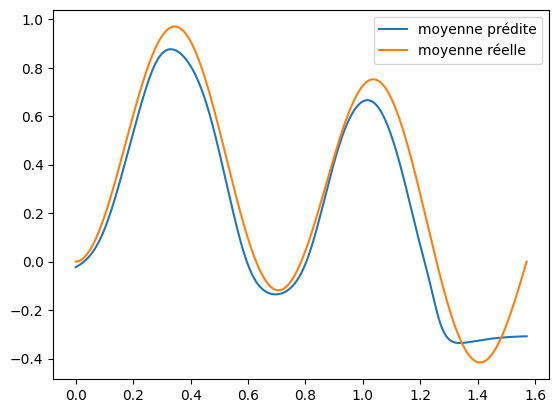

In [ ]:
# Affichage de la moyenne prédite
x_inputs = x_inputs.to(device)
with torch.no_grad():
    y_pred = model_1(x_inputs)
plt.plot(x_inputs.cpu(), y_pred.cpu(), label = "moyenne prédite")
plt.plot(x_inputs.cpu(),[y(xi) for xi in x_inputs], label = "moyenne réelle")
plt.legend()
plt.show()

In [ ]:
# Sauvegarde des poids du réseau
model_saved = model_1.state_dict()

In [ ]:
# Chargement des poids sauvegardés sur un nouveau réseau
model_3 = Net_y_3()             # nouvelle instance
model_3.load_state_dict(model_saved)  # charger les poids
model_3.to(device)             # mettre sur GPU si nécessaire

Net_y_3(
  (fc1): Linear(in_features=1, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=1000, bias=True)
  (fc4): Linear(in_features=1000, out_features=1000, bias=True)
  (fc5): Linear(in_features=1000, out_features=1000, bias=True)
  (fc6): Linear(in_features=1000, out_features=1000, bias=True)
  (fc7): Linear(in_features=1000, out_features=1000, bias=True)
  (fc8): Linear(in_features=1000, out_features=1000, bias=True)
  (fc9): Linear(in_features=1000, out_features=1000, bias=True)
  (fc10): Linear(in_features=1000, out_features=1, bias=True)
)

In [ ]:
# Réseau pour entrainer la variance (pas utilisé pour l'instant)
class Net_var(nn.Module):
    def __init__(self):
        super(Net_var,self).__init__()
        self.fc1 = nn.Linear(1, 1000)
        self.fc2 = nn.Linear(1000,1000)
        self.fc3 = nn.Linear(1000,1000)
        self.fc4 = nn.Linear(1000,1000)
        self.fc5 = nn.Linear(1000,1000)
        self.fc6 = nn.Linear(1000,1000)
        self.fc7 = nn.Linear(1000,1000)
        self.fc8 = nn.Linear(1000,1000)
        self.fc9 = nn.Linear(1000,1000)
        self.fc10 = nn.Linear(1000,1)



    def forward(self,x):
        x_scaled = (x - np.pi/2) / (np.pi/2)  # x_scaled ∈ [-1,1]
        x = self.fc1(x)
        x = F.tanh(x)
        x = self.fc2(x)
        x = F.tanh(x)
        x = self.fc3(x)
        x = F.tanh(x)
        x = self.fc4(x)
        x = F.tanh(x)
        x = self.fc5(x)
        x = F.tanh(x)
        x = self.fc6(x)
        x = F.tanh(x)
        x = self.fc7(x)
        x = F.tanh(x)
        x = self.fc8(x)
        x = F.tanh(x)
        x = self.fc9(x)
        x = F.tanh(x)
        x = self.fc10(x)
        return torch.exp(x)

In [ ]:
# Initialisation du réseau 2
model_2 =  Net_var()
model_2.to(device=device)

Net_var(
  (fc1): Linear(in_features=1, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=1000, bias=True)
  (fc4): Linear(in_features=1000, out_features=1000, bias=True)
  (fc5): Linear(in_features=1000, out_features=1000, bias=True)
  (fc6): Linear(in_features=1000, out_features=1000, bias=True)
  (fc7): Linear(in_features=1000, out_features=1000, bias=True)
  (fc8): Linear(in_features=1000, out_features=1000, bias=True)
  (fc9): Linear(in_features=1000, out_features=1000, bias=True)
  (fc10): Linear(in_features=1000, out_features=1, bias=True)
)

In [ ]:
# On utilise une variance moyenne de 0.05 au départ pour aider le réseau
# On le fait en remplaçant le biais de la dernière couche par log(0.05), puis comme la fonction d'activation est exp on obtient bien au départ une variance moyenne de 0.05
with torch.no_grad():
    # mean_var.item() -> float ; fill_ accepte un float
    model_2.fc10.bias.fill_(log(0.05))

In [ ]:
criterion = nn.GaussianNLLLoss() # specify loss function (categorical cross-entropy)

In [ ]:
optimizer = torch.optim.SGD(model_2.parameters(),lr = 1e-1) # specify optimizer (stochastic gradient descent) and learning rate

In [ ]:
# Entrainement du réseau de la variance seulement

n_epochs = 1500 # number of epochs to train the model

def training_both(n_epochs, train_loader, net_y, net_var, criterion, optimizer, device):

  train_losses = []

  for epoch in range(n_epochs):
      train_loss = 0 # monitor losses

      # entrainement de la moyenne
      net_y.train() # prep model for training
      net_var.train()
      for x, d in train_loader:
          x = x.to(device=device, dtype=torch.float32)
          d = d.to(device=device, dtype=torch.float32)
          optimizer.zero_grad() # clear the gradients of all optimized variables
          mean = net_y(x)
          #print(((d-mean)**2).mean())
          var = net_var(x)
          loss = criterion(d,mean,var)  # calculate the loss
          loss.backward() # backward pass: compute gradient of the loss with respect to model parameters
          optimizer.step() # perform a single optimization step (parameter update)
          train_loss += loss.item() # update running training loss





      # calculate average loss over an epoch
      train_losses.append(train_loss)

      print('epoch: {} \ttraining Loss: {:.6f}'.format(epoch+1, train_loss))

  torch.save(net_y.state_dict(), 'model.pt')

  return train_losses

In [ ]:
train_losses_2 = training_both(n_epochs, train_loader, model_3, model_2, criterion, optimizer, device)


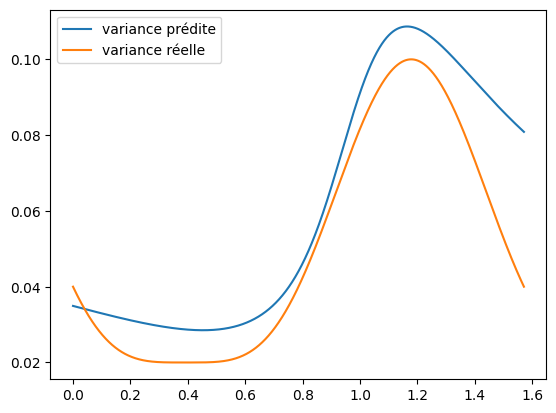

In [ ]:
# Affichage de la variance prédite

x_inputs = x_inputs.to(device)
with torch.no_grad():
    y_pred = model_2(x_inputs)
plt.plot(x_inputs.cpu(), y_pred.cpu(),label = "variance prédite")
plt.plot(x_inputs.cpu(),[noise(xi) for xi in x_inputs], label = "variance réelle")
plt.legend()
plt.show()